In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

In [2]:
# Import data from the colvar files
data_colvar0 = plumed.read_as_pandas("data/COLVAR.0")
data_colvar1 = plumed.read_as_pandas("data/COLVAR.1")
data_colvar2 = plumed.read_as_pandas("data/COLVAR.2")
data_colvar3 = plumed.read_as_pandas("data/COLVAR.3")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3908984155.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar0 = plumed.read_as_pandas("data/COLVAR.0")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3908984155.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar1 = plumed.read_as_pandas("data/COLVAR.1")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3908984155.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar2 = plumed.read_as_pandas("data/COLVAR.2")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3908984155.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar3 = plumed.read_as_pandas("data/COLVAR.3")


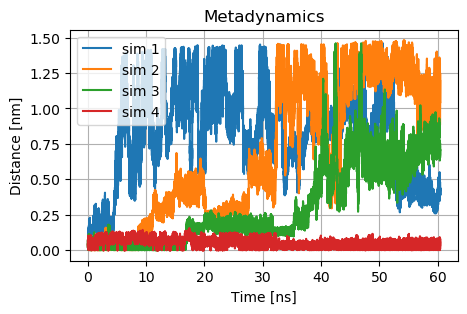

In [3]:
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_colvar0["time"]*0.001, data_colvar0["d1"], label="sim 1")
plt.plot(data_colvar1["time"]*0.001, data_colvar1["d1"], label="sim 2")
plt.plot(data_colvar2["time"]*0.001, data_colvar2["d1"], label="sim 3")
plt.plot(data_colvar3["time"]*0.001, data_colvar3["d1"], label="sim 4")
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

Text(0, 0.5, 'Probability density')

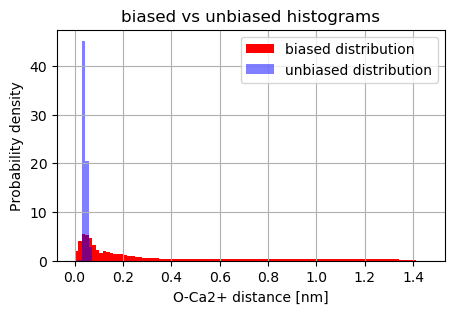

In [6]:
# Attento, qua devi prendere tutti i colvar contemporaneamente

kT = 1
w_0 = [math.exp(data_colvar0["metad.rbias"][i])/kT for i in range(0, len(data_colvar0["metad.rbias"]))]
w_1 = [math.exp(data_colvar1["metad.rbias"][i])/kT for i in range(0, len(data_colvar1["metad.rbias"]))]
w_2 = [math.exp(data_colvar2["metad.rbias"][i])/kT for i in range(0, len(data_colvar2["metad.rbias"]))]
w_3 = [math.exp(data_colvar3["metad.rbias"][i])/kT for i in range(0, len(data_colvar3["metad.rbias"]))]

w = np.concatenate((w_0, w_1, w_2, w_3), axis=None)
d1_colvar = np.concatenate((data_colvar0["d1"], data_colvar1["d1"], data_colvar2["d1"], data_colvar3["d1"]), axis=None)


val_bias, bins_bias, patches_bias = plt.hist(d1_colvar, bins=100, density=True, color='r', label="biased distribution")
kT = 1
val_unbias, bins_unbias, patches_unbias = plt.hist(d1_colvar, bins=100, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")
plt.grid()
plt.legend(loc="best")
plt.title("biased vs unbiased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Reconstruct the free energy profile

In [7]:
def get_fes(bins, val):
    F = []
    s = []
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3300/1812908712.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")


Text(0, 0.5, 'Free energy surface')

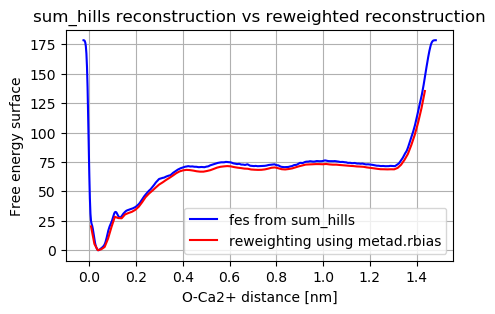

In [9]:
F = []
dist = []
F, dist = get_fes(bins_unbias, val_unbias)

data_fes = plumed.read_as_pandas("fes.dat")
plt.plot(data_fes["d1"], data_fes["file.free"], 'b',label="fes from sum_hills")

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using metad.rbias")
plt.grid()
plt.legend(loc="best")
plt.title("sum_hills reconstruction vs reweighted reconstruction")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")
#plt.xlim([0, 1.2])

# Assessment of convergence

We use the tool `sum_hills` to judge the convergence of the free energy profile as a function of the simulated time. With this command we generate many free energy files (`fes`), each one containing the estimate of the free energy up to that point in time.
```
plumed sum_hills --hills HILLS_shared --stride 40000 --mintozero
```
We recall that in this simulation we deposited the Gaussian kernels with a `PACE=400`. Our time step is 0.002 ps, therefore the `HILLS` file contains values sampled every 0.8 ps. Consequently, plumed will identify the number of deposited Gaussian kernels as 

$$ \text{Number of simulations}\times \frac{\text{Simulated time [ps]}}{ \text{Pace of deposition [ps]}}=4\times\frac{38060.8}{0.8}=190304$$

Therefore our previous command will generate 4 files.

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3267615813.py:7: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3267615813.py:7: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3267615813.py:7: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3267615813.py:7: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1878/3267615813.py:7: UserWarning: cannot load PLUMED instance, conversions will not be avail

Text(0, 0.5, 'Free energies [kJ/mol]')

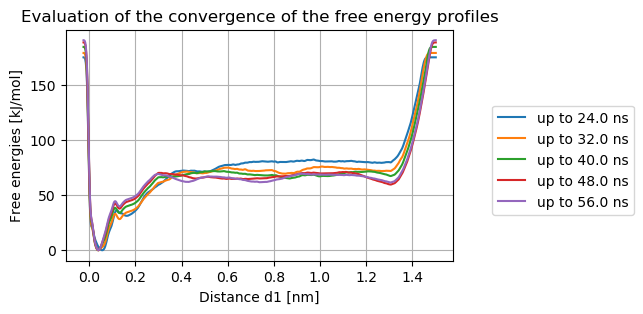

In [4]:

stride = 40000

# metto 0.13 = 0.8/6

for i in range(3, 8):   
    # import fes file into pandas dataset
    data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
    plt.plot(data["d1"],data["file.free"], label="up to "+str(i * stride/1000 * 0.2)+" ns")

plt.grid()
plt.title("Evaluation of the convergence of the free energy profiles")
plt.legend(loc=(1.1, 0.2))
plt.xlabel("Distance d1 [nm]")
plt.ylabel("Free energies [kJ/mol]")

# Comparison with the single-walker trajectory

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3040/2048304498.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_single_w = plumed.read_as_pandas("../../membr_Rec/fes.dat")


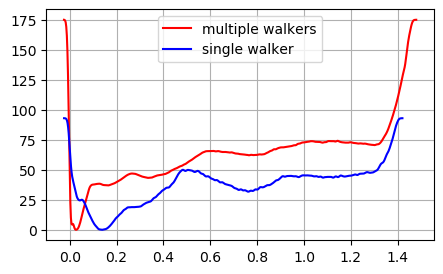

In [18]:
data_single_w = plumed.read_as_pandas("../../membr_Rec/fes.dat")
plt.plot(data_fes["d1"],data_fes["file.free"], 'r', label="multiple walkers")
plt.plot(data_single_w["d1"],data_single_w["file.free"], 'b', label="single walker")
plt.grid()
plt.legend(loc="best")

The shape reported by Ester seems to recall the shape of multiple walkers `fes.dat`. Not only the position of the minimum is recovered, but also the shape. Ester did not get the strange minima/maxima in the first part of the plot. 